## Logistic regression on medium set

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
# First, let's examine the data structure to identify column names
def examine_dataframe(df):
    """Print the structure of the dataframe to identify column names"""
    print("DataFrame columns:", df.columns.tolist())
    print("First row sample:", df.iloc[0].to_dict())
    return df.columns.tolist()


# Get the absolute path of the current notebook
notebook_path = os.path.abspath('')

# Navigate to the project root (CS182-Final-Project)
project_root = os.path.dirname(notebook_path)
os.chdir(project_root)

print("Loading data...")
train_data = pickle.load(open('data/medium_set/train_data.pkl', 'rb'))
cv_data = pickle.load(open('data/medium_set/validation_data.pkl', 'rb'))
test1_data = pickle.load(open('data/medium_set/test1_data.pkl', 'rb'))
test2_data = pickle.load(open('data/medium_set/test2_data.pkl', 'rb'))

# Examine structure of the first dataframe to understand its format
print("\nExamining training data structure:")
examine_dataframe(train_data)

print("\nLoading protein embeddings...")
protein_embeddings = pickle.load(open('data/full_dataset/embeddings/embeddings_merged.pkl', 'rb'))
print(f"Loaded {len(protein_embeddings)} protein embeddings")

print(train_data.head())
for i, (key, value) in enumerate(protein_embeddings.items()):
    if i >= 5:
        break
    print(f"Protein ID: {key}, Embedding shape: {value.shape}")


Loading data...

Examining training data structure:
DataFrame columns: ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B']
First row sample: {'uniprotID_A': 'Q92529', 'uniprotID_B': 'Q9H6L4', 'isInteraction': 0, 'trainTest': 'train', 'sequence_A': 'MLPRTKYNRFRNDSVTSVDDLLHSLSVSGGGGKVSAARATPAAAPYLVSGEALRKAPDDGPGSLGHLLHKVSHLKLSSSGLRGLSSAARERAGARLSGSCSAPSLAAPDGSAPSAPRAPAMSAARKGRPGDEPLPRPPRGAPHASDQVLGPGVTYVVKYLGCIEVLRSMRSLDFSTRTQITREAISRVCEAVPGAKGAFKKRKPPSKMLSSILGKSNLQFAGMSISLTISTASLNLRTPDSKQIIANHHMRSISFASGGDPDTTDYVAYVAKDPVNRRACHILECCDGLAQDVIGSIGQAFELRFKQYLQCPTKIPALHDRMQSLDEPWTEEEGDGSDHPYYNSIPSKMPPPGGFLDTRLKPRPHAPDTAQFAGKEQTYYQGRHLGDTFGEDWQQTPLRQGSSDIYSTPEGKLHVAPTGEAPTYVNTQQIPPQAWPAAVSSAESSPRKDLFDMKPFEDALKNQPLGPVLSKAASVECISPVSPRAPDAKMLEELQAETWYQGEMSRKEAEGLLEKDGDFLVRKSTTNPGSFVLTGMHNGQAKHLLLVDPEGTIRTKDRVFDSISHLINHHLESSLPIVSAGSELCLQQPVERKQ', 'sequence_B': 'MAQKPKVDPHVGRLGYLQALVTEFQETQSQDAKEQVLANLANFAYDPSNYEYLRQLQVLDLFLDSLSEENETLVEFAIGGLCNLCPDRANKEHILHAGGVPL

In [4]:
def create_features(embA, embB, method='all'):
    """Create combined features from protein embeddings"""
    if method == 'all':
        return np.concatenate([embA, embB, np.abs(embA - embB), embA * embB], axis=1)
    elif method == 'add_sub':
        return np.concatenate([embA + embB, embA - embB], axis=1)
    elif method == 'mul_only':
        return embA * embB
    elif method == 'concatenate':
        return np.concatenate([embA, embB], axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")

def extract_embeddings_separate(data_df, embeddings_dict, batch_size=100):
    """Extract separate embeddings for protein A and B"""
    columns = data_df.columns.tolist()
    
    # Find column names
    protein_a_col = None
    protein_b_col = None
    interaction_col = None
    
    protein_a_patterns = ['protein_a', 'protein_id_a', 'proteinA', 'proteinIDA', 'protein_A', 'protein_id_A', 'uniprotID_A']
    protein_b_patterns = ['protein_b', 'protein_id_b', 'proteinB', 'proteinIDB', 'protein_B', 'protein_id_B', 'uniprotID_B']
    interaction_patterns = ['isInteraction', 'is_interaction', 'interaction', 'label']
    
    for col in columns:
        col_lower = col.lower()
        if any(pattern.lower() in col_lower for pattern in protein_a_patterns):
            protein_a_col = col
        elif any(pattern.lower() in col_lower for pattern in protein_b_patterns):
            protein_b_col = col
        elif any(pattern.lower() in col_lower for pattern in interaction_patterns):
            interaction_col = col
    
    if protein_a_col is None or protein_b_col is None:
        first_row = data_df.iloc[0].to_dict()
        for col, val in first_row.items():
            if isinstance(val, str) and val in embeddings_dict:
                if protein_a_col is None:
                    protein_a_col = col
                elif protein_b_col is None and col != protein_a_col:
                    protein_b_col = col
    
    print(f"Using columns: Protein A = '{protein_a_col}', Protein B = '{protein_b_col}', Interaction = '{interaction_col}'")
    
    embA_list = []
    embB_list = []
    y_list = []
    skipped = 0
    
    for i in tqdm(range(0, len(data_df), batch_size), desc="Extracting embeddings"):
        batch = data_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            protein_A = row[protein_a_col]
            protein_B = row[protein_b_col]
            
            if protein_A not in embeddings_dict or protein_B not in embeddings_dict:
                skipped += 1
                continue
            
            embedding_A = embeddings_dict[protein_A]
            embedding_B = embeddings_dict[protein_B]
            
            # Mean pooling
            if isinstance(embedding_A, torch.Tensor):
                if embedding_A.dim() == 3:  # Handle (1, seq_len, dim)
                    feat_A = embedding_A[0].mean(dim=0).cpu().numpy()
                    feat_B = embedding_B[0].mean(dim=0).cpu().numpy()
                else:  # Handle (seq_len, dim)
                    feat_A = embedding_A.mean(dim=0).cpu().numpy()
                    feat_B = embedding_B.mean(dim=0).cpu().numpy()
            else:
                if len(embedding_A.shape) == 3:
                    feat_A = embedding_A[0].mean(axis=0)
                    feat_B = embedding_B[0].mean(axis=0)
                else:
                    feat_A = embedding_A.mean(axis=0)
                    feat_B = embedding_B.mean(axis=0)
            
            embA_list.append(feat_A)
            embB_list.append(feat_B)
            y_list.append(row[interaction_col])
    
    print(f"Processed {len(embA_list)} protein pairs. Skipped {skipped} pairs.")
    return np.array(embA_list), np.array(embB_list), np.array(y_list)

# Extract separate embeddings for all datasets
print("Extracting separate embeddings...")
train_embA, train_embB, train_y = extract_embeddings_separate(train_data, protein_embeddings)
val_embA, val_embB, val_y = extract_embeddings_separate(cv_data, protein_embeddings)
test1_embA, test1_embB, test1_y = extract_embeddings_separate(test1_data, protein_embeddings)
test2_embA, test2_embB, test2_y = extract_embeddings_separate(test2_data, protein_embeddings)

print(f"Train embeddings: A={train_embA.shape}, B={train_embB.shape}, y={train_y.shape}")
print(f"Val embeddings: A={val_embA.shape}, B={val_embB.shape}, y={val_y.shape}")
print(f"Test1 embeddings: A={test1_embA.shape}, B={test1_embB.shape}, y={test1_y.shape}")
print(f"Test2 embeddings: A={test2_embA.shape}, B={test2_embB.shape}, y={test2_y.shape}")

Extracting separate embeddings...
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting embeddings: 100%|██████████| 100/100 [00:04<00:00, 22.27it/s]


Processed 10000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting embeddings: 100%|██████████| 20/20 [00:00<00:00, 21.18it/s]


Processed 2000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting embeddings: 100%|██████████| 20/20 [00:01<00:00, 14.23it/s]


Processed 2000 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting embeddings: 100%|██████████| 100/100 [00:04<00:00, 21.72it/s]

Processed 10000 protein pairs. Skipped 0 pairs.
Train embeddings: A=(10000, 960), B=(10000, 960), y=(10000,)
Val embeddings: A=(2000, 960), B=(2000, 960), y=(2000,)
Test1 embeddings: A=(2000, 960), B=(2000, 960), y=(2000,)
Test2 embeddings: A=(10000, 960), B=(10000, 960), y=(10000,)


In [5]:
# Create combined features using different methods - OPTIMIZED VERSION
feature_methods = ['concatenate', 'mul_only', 'add_sub']  # Removed 'all' to reduce memory usage

# Store features for each method
features_dict = {}

# Add memory monitoring
import psutil
import time

def check_memory():
    """Check current memory usage"""
    memory = psutil.virtual_memory()
    print(f"Memory usage: {memory.percent:.1f}% ({memory.used/1024**3:.1f}GB/{memory.total/1024**3:.1f}GB)")
    return memory.percent

print("Initial memory check:")
check_memory()

for method in feature_methods:
    print(f"\nCreating features using method: {method}")
    
    # Create training features
    X_train = create_features(train_embA, train_embB, method=method)
    X_val = create_features(val_embA, val_embB, method=method)
    X_test1 = create_features(test1_embA, test1_embB, method=method)
    X_test2 = create_features(test2_embA, test2_embB, method=method)
    
    print(f"Feature shapes for {method}:")
    print(f"  Train: {X_train.shape}")
    print(f"  Val: {X_val.shape}")
    print(f"  Test1: {X_test1.shape}")
    print(f"  Test2: {X_test2.shape}")
    
    # Store in dictionary
    features_dict[method] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test1': X_test1,
        'X_test2': X_test2
    }
    
    # Memory check after each method
    memory_percent = check_memory()
    if memory_percent > 85:
        print("WARNING: High memory usage detected!")
        gc.collect()
        time.sleep(1)

# Check class distribution
print(f"\nClass distribution:")
print(f"Train: {np.bincount(train_y)} (ratio: {train_y.mean():.3f})")
print(f"Val: {np.bincount(val_y)} (ratio: {val_y.mean():.3f})")
print(f"Test1: {np.bincount(test1_y)} (ratio: {test1_y.mean():.3f})")
print(f"Test2: {np.bincount(test2_y)} (ratio: {test2_y.mean():.3f})")

Initial memory check:
Memory usage: 82.1% (24.4GB/31.1GB)

Creating features using method: concatenate
Feature shapes for concatenate:
  Train: (10000, 1920)
  Val: (2000, 1920)
  Test1: (2000, 1920)
  Test2: (10000, 1920)
Memory usage: 82.4% (24.5GB/31.1GB)

Creating features using method: mul_only
Feature shapes for mul_only:
  Train: (10000, 960)
  Val: (2000, 960)
  Test1: (2000, 960)
  Test2: (10000, 960)
Memory usage: 82.7% (24.6GB/31.1GB)

Creating features using method: add_sub
Feature shapes for add_sub:
  Train: (10000, 1920)
  Val: (2000, 1920)
  Test1: (2000, 1920)
  Test2: (10000, 1920)
Memory usage: 83.2% (24.8GB/31.1GB)

Class distribution:
Train: [5000 5000] (ratio: 0.500)
Val: [1000 1000] (ratio: 0.500)
Test1: [1000 1000] (ratio: 0.500)
Test2: [9100  900] (ratio: 0.090)


In [7]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, dataset_name=""):
    """Comprehensive model evaluation"""
    results = {}
    
    # Basic metrics
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, zero_division=0)
    
    # AUC if probabilities available
    if y_pred_proba is not None:
        try:
            results['auc'] = roc_auc_score(y_true, y_pred_proba)
        except ValueError:
            results['auc'] = 0.0
    
    print(f"\n{dataset_name} Results:")
    for metric, value in results.items():
        print(f"  {metric.upper()}: {value:.4f}")
    
    return results

# SIMPLIFIED hyperparameter grid to prevent getting stuck
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Reduced from 6 to 4 values
    'penalty': ['l2'],  # Only l2 to reduce complexity
    'solver': ['lbfgs'],  # More efficient solver for l2
    'max_iter': [500]  # Reduced iterations
}

print(f"Grid search will test {len(param_grid['C']) * len(param_grid['penalty'])} combinations")

# Store results for each feature method
results_summary = {}

# Add timeout and progress monitoring
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import signal

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Grid search timed out!")

for method in feature_methods:
    print(f"\n{'='*50}")
    print(f"Training Logistic Regression with {method} features")
    print(f"{'='*50}")
    
    # Memory check before training
    memory_percent = check_memory()
    if memory_percent > 80:
        print("High memory usage - running garbage collection...")
        gc.collect()
        time.sleep(2)
    
    # Get features for this method
    X_train = features_dict[method]['X_train']
    X_val = features_dict[method]['X_val']
    X_test1 = features_dict[method]['X_test1']
    X_test2 = features_dict[method]['X_test2']
    
    print(f"Feature dimensions: {X_train.shape}")
    
    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test1_scaled = scaler.transform(X_test1)
    X_test2_scaled = scaler.transform(X_test2)
    
    # Grid search with timeout protection
    print("Performing grid search with timeout protection...")
    lr = LogisticRegression(random_state=42)
    
    try:
        # Set timeout for grid search (10 minutes max)
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(600)  # 10 minutes timeout
        
        # Reduced CV folds and limited jobs to prevent overload
        grid_search = GridSearchCV(
            lr, param_grid, 
            cv=3,  # Reduced from 5 to 3 folds
            scoring='f1',
            n_jobs=2,  # Limited parallel jobs
            verbose=1
        )
        
        start_time = time.time()
        grid_search.fit(X_train_scaled, train_y)
        end_time = time.time()
        
        # Cancel timeout
        signal.alarm(0)
        
        print(f"Grid search completed in {end_time - start_time:.1f} seconds")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV F1 score: {grid_search.best_score_:.4f}")
        
        # Get the best model
        best_lr = grid_search.best_estimator_
        
    except (TimeoutException, KeyboardInterrupt):
        print("Grid search timed out or was interrupted! Using default parameters...")
        signal.alarm(0)
        
        # Fallback to simple logistic regression with default parameters
        best_lr = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=500, random_state=42)
        best_lr.fit(X_train_scaled, train_y)
        
        # Create dummy grid search results
        class DummyGridSearch:
            def __init__(self):
                self.best_params_ = {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 500}
                self.best_score_ = 0.0
        
        grid_search = DummyGridSearch()
    
    # Evaluate on all datasets with progress tracking
    method_results = {}
    
    print("Evaluating on datasets...")
    
    # Training set
    print("  - Training set...")
    train_pred = best_lr.predict(X_train_scaled)
    train_proba = best_lr.predict_proba(X_train_scaled)[:, 1]
    method_results['train'] = evaluate_model(train_y, train_pred, train_proba, "Training")
    
    # Validation set
    print("  - Validation set...")
    val_pred = best_lr.predict(X_val_scaled)
    val_proba = best_lr.predict_proba(X_val_scaled)[:, 1]
    method_results['val'] = evaluate_model(val_y, val_pred, val_proba, "Validation")
    
    # Test set 1
    print("  - Test set 1...")
    test1_pred = best_lr.predict(X_test1_scaled)
    test1_proba = best_lr.predict_proba(X_test1_scaled)[:, 1]
    method_results['test1'] = evaluate_model(test1_y, test1_pred, test1_proba, "Test1")
    
    # Test set 2
    print("  - Test set 2...")
    test2_pred = best_lr.predict(X_test2_scaled)
    test2_proba = best_lr.predict_proba(X_test2_scaled)[:, 1]
    method_results['test2'] = evaluate_model(test2_y, test2_pred, test2_proba, "Test2")
    
    # Store results
    results_summary[method] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'model': best_lr,
        'scaler': scaler,
        'results': method_results
    }
    
    # Aggressive cleanup after each method
    del X_train_scaled, X_val_scaled, X_test1_scaled, X_test2_scaled
    del train_pred, train_proba, val_pred, val_proba, test1_pred, test1_proba, test2_pred, test2_proba
    gc.collect()
    
    print(f"Completed {method} method. Memory usage:")
    check_memory()
    
    # Brief pause to let system recover
    time.sleep(1)

print("\nAll methods completed successfully!")

Grid search will test 4 combinations

Training Logistic Regression with concatenate features
Memory usage: 83.2% (24.7GB/31.1GB)
High memory usage - running garbage collection...
Feature dimensions: (10000, 1920)
Scaling features...
Performing grid search with timeout protection...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Grid search completed in 79.1 seconds
Best parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score: 0.5030
Evaluating on datasets...
  - Training set...

Training Results:
  ACCURACY: 0.6800
  PRECISION: 0.6804
  RECALL: 0.6790
  F1: 0.6797
  AUC: 0.7496
  - Validation set...

Validation Results:
  ACCURACY: 0.5170
  PRECISION: 0.5167
  RECALL: 0.5250
  F1: 0.5208
  AUC: 0.5242
  - Test set 1...

Test1 Results:
  ACCURACY: 0.5025
  PRECISION: 0.5025
  RECALL: 0.5080
  F1: 0.5052
  AUC: 0.5084
  - Test set 2...

Test2 Results:
  ACCURACY: 0.5134
  PRECISION: 0.0978
  RECALL: 0.5356
  F1: 0.1654
  AUC: 0.5323
Completed concatenate method. Memory usage:
Memory usage: 84.8% (25.3GB/31.1GB)

Training Logistic Regression with mul_only features
Memory usage: 84.9% (25.3GB/31.1GB)
High memory usage - running garbage collection...
Feature dimensions: (10000, 960)
Scaling features...
Performing grid search with timeout protection...
Fitting 3 folds for each of 

/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Grid search completed in 83.3 seconds
Best parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score: 0.5038
Evaluating on datasets...
  - Training set...

Training Results:
  ACCURACY: 0.6805
  PRECISION: 0.6805
  RECALL: 0.6804
  F1: 0.6805
  AUC: 0.7498
  - Validation set...

Validation Results:
  ACCURACY: 0.5135
  PRECISION: 0.5133
  RECALL: 0.5210
  F1: 0.5171
  AUC: 0.5244
  - Test set 1...

Test1 Results:
  ACCURACY: 0.4995
  PRECISION: 0.4995
  RECALL: 0.5060
  F1: 0.5027
  AUC: 0.5081
  - Test set 2...

Test2 Results:
  ACCURACY: 0.5124
  PRECISION: 0.0964
  RECALL: 0.5278
  F1: 0.1631
  AUC: 0.5321
Completed add_sub method. Memory usage:
Memory usage: 84.8% (25.3GB/31.1GB)

All methods completed successfully!


In [8]:
# Create comprehensive results summary - MEMORY EFFICIENT VERSION
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# Create a DataFrame for easy comparison
summary_data = []
for method in feature_methods:
    for dataset in ['train', 'val', 'test1', 'test2']:
        row = {'method': method, 'dataset': dataset}
        row.update(results_summary[method]['results'][dataset])
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Display results by metric
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
for metric in metrics:
    print(f"\n{metric.upper()} Results:")
    try:
        pivot_table = summary_df.pivot(index='method', columns='dataset', values=metric)
        print(pivot_table.round(4))
    except Exception as e:
        print(f"Error creating pivot table for {metric}: {e}")
        # Fallback to simple display
        for method in feature_methods:
            print(f"{method}:")
            for dataset in ['train', 'val', 'test1', 'test2']:
                value = results_summary[method]['results'][dataset][metric]
                print(f"  {dataset}: {value:.4f}")

# Find best method for each dataset based on F1 score
print(f"\nBest F1 scores by dataset:")
try:
    for dataset in ['val', 'test1', 'test2']:
        dataset_data = summary_df[summary_df['dataset'] == dataset]
        if not dataset_data.empty:
            best_idx = dataset_data['f1'].idxmax()
            best_method = dataset_data.loc[best_idx, 'method']
            best_f1 = dataset_data.loc[best_idx, 'f1']
            print(f"  {dataset}: {best_method} (F1: {best_f1:.4f})")
except Exception as e:
    print(f"Error finding best methods: {e}")
    # Fallback
    for dataset in ['val', 'test1', 'test2']:
        best_f1 = 0
        best_method = feature_methods[0]
        for method in feature_methods:
            f1 = results_summary[method]['results'][dataset]['f1']
            if f1 > best_f1:
                best_f1 = f1
                best_method = method
        print(f"  {dataset}: {best_method} (F1: {best_f1:.4f})")


COMPREHENSIVE RESULTS SUMMARY

ACCURACY Results:
dataset       test1   test2   train     val
method                                     
add_sub      0.4995  0.5124  0.6805  0.5135
concatenate  0.5025  0.5134  0.6800  0.5170
mul_only     0.5835  0.5803  0.6846  0.5985

PRECISION Results:
dataset       test1   test2   train     val
method                                     
add_sub      0.4995  0.0964  0.6805  0.5133
concatenate  0.5025  0.0978  0.6804  0.5167
mul_only     0.5786  0.1305  0.6831  0.5978

RECALL Results:
dataset      test1   test2   train    val
method                                   
add_sub      0.506  0.5278  0.6804  0.521
concatenate  0.508  0.5356  0.6790  0.525
mul_only     0.615  0.6467  0.6886  0.602

F1 Results:
dataset       test1   test2   train     val
method                                     
add_sub      0.5027  0.1631  0.6805  0.5171
concatenate  0.5052  0.1654  0.6797  0.5208
mul_only     0.5962  0.2171  0.6859  0.5999

AUC Results:
dataset       te

In [9]:
# Select the best performing method based on validation F1 score
val_f1_scores = {method: results_summary[method]['results']['val']['f1'] for method in feature_methods}
best_method = max(val_f1_scores, key=val_f1_scores.get)

print(f"Best method based on validation F1: {best_method}")
print(f"Validation F1 score: {val_f1_scores[best_method]:.4f}")

# Get the best model and its components
best_model = results_summary[best_method]['model']
best_scaler = results_summary[best_method]['scaler']
best_params = results_summary[best_method]['best_params']

print(f"\nBest hyperparameters: {best_params}")

# Detailed analysis on test sets
print(f"\n{'='*50}")
print(f"DETAILED ANALYSIS - {best_method.upper()} METHOD")
print(f"{'='*50}")

# Get scaled features for the best method
print("Preparing test data...")
X_test1_scaled = best_scaler.transform(features_dict[best_method]['X_test1'])
X_test2_scaled = best_scaler.transform(features_dict[best_method]['X_test2'])

# Predictions and probabilities
print("Making predictions...")
test1_pred = best_model.predict(X_test1_scaled)
test1_proba = best_model.predict_proba(X_test1_scaled)[:, 1]
test2_pred = best_model.predict(X_test2_scaled)
test2_proba = best_model.predict_proba(X_test2_scaled)[:, 1]

# Confusion matrices
print("\nConfusion Matrices:")
print("\nTest1:")
cm1 = confusion_matrix(test1_y, test1_pred)
print(cm1)
print("\nTest2:")
cm2 = confusion_matrix(test2_y, test2_pred)
print(cm2)

# Classification reports (simplified)
print("\nClassification Reports:")
print("\nTest1:")
try:
    print(classification_report(test1_y, test1_pred))
except:
    print("Error generating classification report for Test1")

print("\nTest2:")
try:
    print(classification_report(test2_y, test2_pred))
except:
    print("Error generating classification report for Test2")

# Clean up
del X_test1_scaled, X_test2_scaled
gc.collect()

Best method based on validation F1: mul_only
Validation F1 score: 0.5999

Best hyperparameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

DETAILED ANALYSIS - MUL_ONLY METHOD
Preparing test data...
Making predictions...

Confusion Matrices:

Test1:
[[552 448]
 [385 615]]

Test2:
[[5221 3879]
 [ 318  582]]

Classification Reports:

Test1:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57      1000
           1       0.58      0.61      0.60      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000


Test2:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71      9100
           1       0.13      0.65      0.22       900

    accuracy                           0.58     10000
   macro avg       0.54      0.61      0.47     10000
weighted avg       0.87      0

0

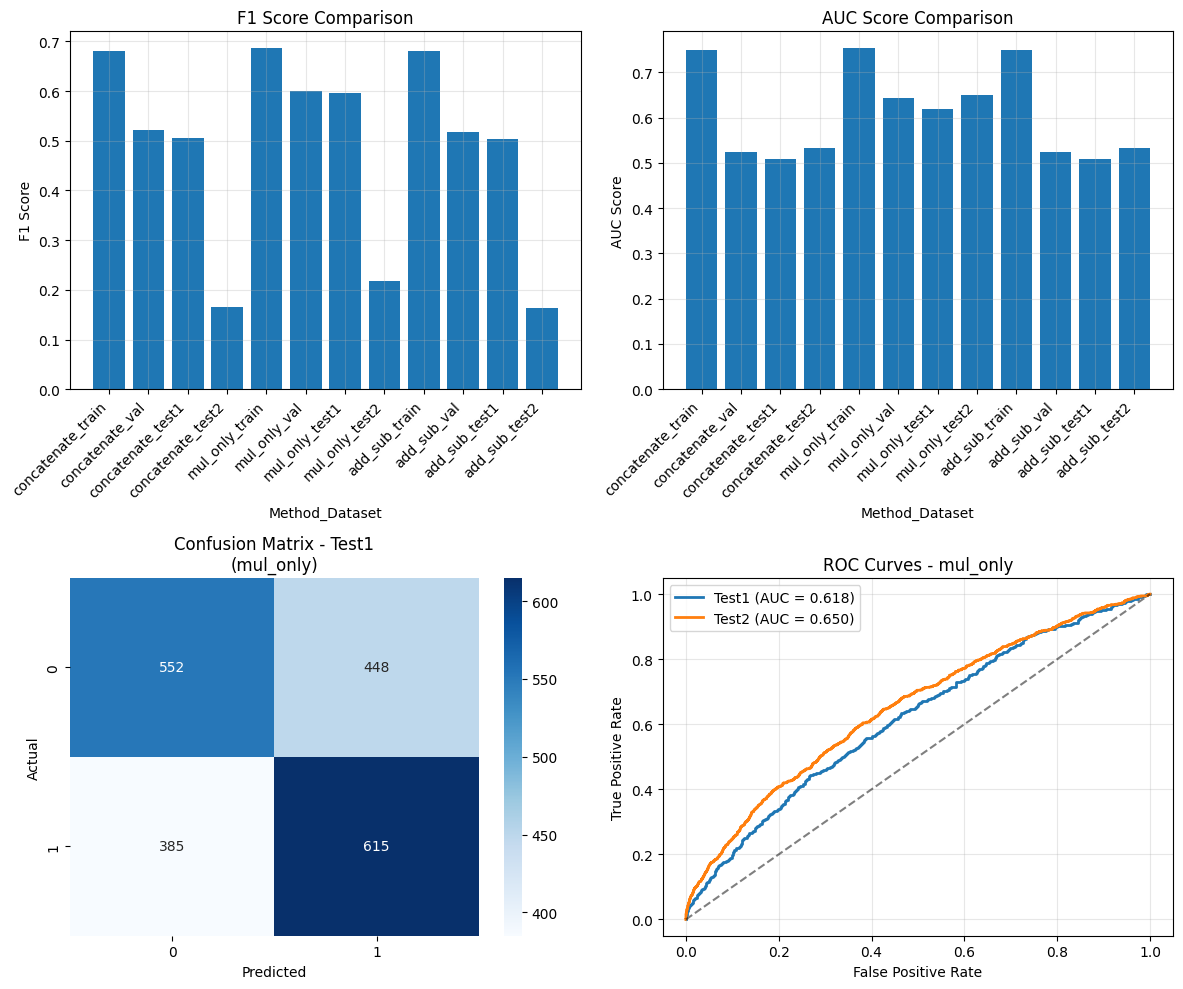


FINAL SUMMARY
Best method: mul_only
Best hyperparameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

Final Test Results:
Test1 - F1: 0.5962, AUC: 0.6182
Test2 - F1: 0.2171, AUC: 0.6500

Final memory usage:
Memory usage: 85.1% (25.3GB/31.1GB)


85.1

In [10]:
# Create visualizations - MEMORY SAFE VERSION
try:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Reduced from 2x3 to 2x2
    
    # 1. F1 scores comparison
    ax = axes[0, 0]
    datasets = ['train', 'val', 'test1', 'test2']
    
    # Simple bar plot instead of grouped bars
    f1_data = []
    labels = []
    for method in feature_methods:
        for dataset in datasets:
            f1_data.append(results_summary[method]['results'][dataset]['f1'])
            labels.append(f"{method}_{dataset}")
    
    ax.bar(range(len(f1_data)), f1_data)
    ax.set_xlabel('Method_Dataset')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Score Comparison')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # 2. AUC scores comparison
    ax = axes[0, 1]
    auc_data = []
    for method in feature_methods:
        for dataset in datasets:
            auc_data.append(results_summary[method]['results'][dataset]['auc'])
    
    ax.bar(range(len(auc_data)), auc_data)
    ax.set_xlabel('Method_Dataset')
    ax.set_ylabel('AUC Score')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # 3. Confusion matrix for best model on Test1
    ax = axes[1, 0]
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - Test1\n({best_method})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # 4. ROC curves for best model
    from sklearn.metrics import roc_curve
    ax = axes[1, 1]
    
    # Test1 ROC
    fpr1, tpr1, _ = roc_curve(test1_y, test1_proba)
    auc1 = roc_auc_score(test1_y, test1_proba)
    ax.plot(fpr1, tpr1, label=f'Test1 (AUC = {auc1:.3f})', linewidth=2)
    
    # Test2 ROC
    fpr2, tpr2, _ = roc_curve(test2_y, test2_proba)
    auc2 = roc_auc_score(test2_y, test2_proba)
    ax.plot(fpr2, tpr2, label=f'Test2 (AUC = {auc2:.3f})', linewidth=2)
    
    # Diagonal line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves - {best_method}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating visualizations: {e}")
    print("Skipping visualization to prevent system hang...")

# Print final summary
print(f"\n{'='*60}")
print(f"FINAL SUMMARY")
print(f"{'='*60}")
print(f"Best method: {best_method}")
print(f"Best hyperparameters: {best_params}")
print(f"\nFinal Test Results:")
print(f"Test1 - F1: {results_summary[best_method]['results']['test1']['f1']:.4f}, AUC: {results_summary[best_method]['results']['test1']['auc']:.4f}")
print(f"Test2 - F1: {results_summary[best_method]['results']['test2']['f1']:.4f}, AUC: {results_summary[best_method]['results']['test2']['auc']:.4f}")

# Final memory check
print(f"\nFinal memory usage:")
check_memory()

In [12]:
# Save the best model and results - SAFE VERSION
import joblib

try:
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Save the best model
    model_filename = f'results/best_logistic_regression_{best_method}.pkl'
    joblib.dump({
        'model': best_model,
        'scaler': best_scaler,
        'method': best_method,
        'params': best_params,
        'results': results_summary[best_method]['results']
    }, model_filename)
    
    print(f"Best model saved to: {model_filename}")
    
    # Save detailed results
    results_filename = 'results/logistic_regression_results.pkl'
    joblib.dump(results_summary, results_filename)
    print(f"All results saved to: {results_filename}")
    
    # Save summary DataFrame
    if 'summary_df' in locals():
        summary_df.to_csv('results/logistic_regression_summary.csv', index=False)
        print(f"Summary table saved to: results/logistic_regression_summary.csv")
    
    print(f"\nModel training and evaluation complete!")
    print(f"Best performing method: {best_method}")
    print(f"Ready for deployment or further analysis.")
    
except Exception as e:
    print(f"Error saving results: {e}")
    print("Results are still available in memory.")

# Final cleanup
gc.collect()
print("Memory cleanup completed.")

Best model saved to: results/best_logistic_regression_mul_only.pkl
All results saved to: results/logistic_regression_results.pkl
Summary table saved to: results/logistic_regression_summary.csv

Model training and evaluation complete!
Best performing method: mul_only
Ready for deployment or further analysis.
Memory cleanup completed.


## Future work

### 1. Pooling alternatives that still yield a single vector

| Pooling method          | Quick description                                                                                                                                                     | When it helps                                                                                                                                |
| ----------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **Max-pool**            | `torch.max(res_embeds, dim=0).values`                                                                                                                                 | Highlights the single strongest residue signal. Often complements mean.                                                                      |
| **Mean + Std**          | concatenate mean and per-feature std-dev → 1920-d                                                                                                                     | Captures dispersion; useful if only a subset of positions carries interface info.                                                            |
| **Attention-style**     | Pre-compute weights $a_i = \frac{\exp(\mathbf v^\top \mathbf e_i)}{\sum_j \exp(\mathbf v^\top \mathbf e_j)}$ with a learned $\mathbf v$, then $\sum_i a_i\mathbf e_i$ | Gives you a *learned* weighted average without leaving the linear world – you learn **v** once, freeze it, then LR sees the weighted vector. |
| **Top-k pooling**       | Sort residues by a relevance score (e.g., L2-norm), keep the top-k, average them                                                                                      | Keeps the most “active’’ positions, reduces noise from tails.                                                                                |
| **PCA / Truncated-SVD** | Run PCA over all residue embeddings across your training set; keep the first $K$ components (e.g., 100) and average the coefficient scores per protein                | Drastically shrinks dimensionality and decorrelates features.                                                                                |
